In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns


In [2]:
train_ds, val_ds = keras.utils.text_dataset_from_directory(
    './aclImdb/train/',
    validation_split= 0.2,
    subset='both',
    seed=225,
)

test_ds = keras.utils.text_dataset_from_directory(
    './aclImdb/test/',
    seed=225,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [9]:
max_tokens = 20000
max_length = 600

text_vectorizer = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_length,
)

text_only_train_ds = train_ds.map(lambda x, y: x)

text_vectorizer.adapt(text_only_train_ds)

In [10]:
int_train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
int_val_ds = val_ds.map(lambda x, y: (text_vectorizer(x), y))
int_test_ds = test_ds.map(lambda x, y: (text_vectorizer(x), y))

In [11]:
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        
        self.attention = keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
        )
        
        self.dense_proj = keras.Sequential([
            keras.layers.Dense(dense_dim, activation='relu'),
            keras.layers.Dense(embed_dim),
        ], name='dense-projection')
        
        self.layernorm1 = keras.layers.LayerNormalization()
        self.layernorm2 = keras.layers.LayerNormalization()
        
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

In [12]:
class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.token_embedding = keras.layers.Embedding(
            input_dim=input_dim, output_dim=output_dim
        )
        
        self.positional_embedding = keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
    
    def call(self, inputs,):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        embeded_tokens = self.token_embedding(inputs)
        embeded_positions = self.positional_embedding(positions)
        
        return embeded_tokens + embeded_positions
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
        config = super().get_config()
        
        config.update({
            'sequence_length' : self.sequence_length, 
            'input_dim' : self.input_dim, 
            'output_dim' : self.output_dim,
        })
        return config

In [13]:
vocab_size = max_tokens
sequence_length = max_length
embed_dim = 256
num_heads = 2
dense_dim = 12

In [15]:
inputs = keras.Input(shape=(None,), dtype='int64')

x = PositionalEmbedding(sequence_length=sequence_length, input_dim=vocab_size, output_dim=embed_dim,)(inputs)
x = TransformerEncoder(embed_dim=embed_dim, dense_dim=dense_dim, num_heads=num_heads)(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dropout(0.4)(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary(expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding_1 (Pos  (None, None, 256)        5273600   
 itionalEmbedding)                                               
                                                                 
 transformer_encoder_1 (Tran  (None, None, 256)        533516    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [16]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint('checkpoints/transformer.h5', save_weights_only=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5)
]

history = model.fit(int_train_ds, validation_data=int_val_ds, batch_size=128, epochs=10, callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 94s 144ms/step - loss: 0.5227 - accuracy: 0.7512 - val_loss: 0.3185 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 65s 104ms/step - loss: 0.3010 - accuracy: 0.8716 - val_loss: 0.2797 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 56s 89ms/step - loss: 0.2317 - accuracy: 0.9078 - val_loss: 0.2843 - val_accuracy: 0.8834 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 56s 89ms/step - loss: 0.1911 - accuracy: 0.9257 - val_loss: 0.2978 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 56s 89ms/step - loss: 0.1613 - accuracy: 0.9397 - val_loss: 0.3268 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 54s 86ms/step - loss: 0.1351 - accuracy: 0.9492 - val_loss: 0.4143 - val_accuracy: 0.8834 - lr: 0.0010
Epoch 7/10
625/625 [==============================] - 52

<AxesSubplot: >

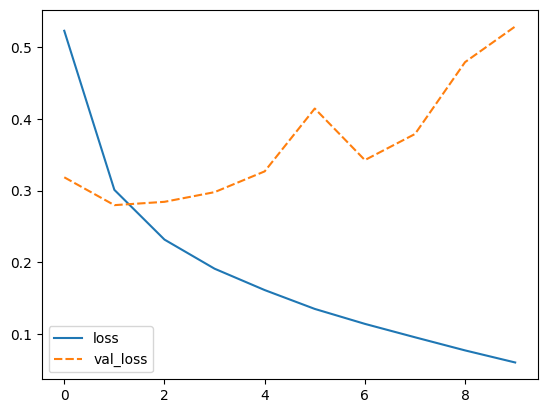

In [18]:
sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})

<AxesSubplot: >

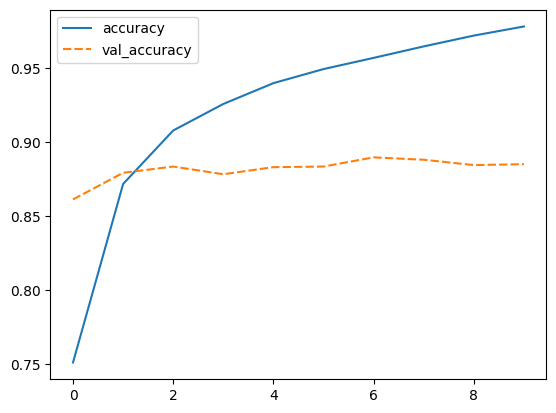

In [19]:
sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']})

In [21]:
model.load_weights('checkpoints/transformer.h5')

In [22]:
model.evaluate(int_test_ds)

782/782 [==============================] - 26s 33ms/step - loss: 0.6299 - accuracy: 0.8652


[0.6299138069152832, 0.8651599884033203]